In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

<div style="text-align:center; background-color:#dc3545; padding:20px;">
  <h1 style="font-size:36px; color:#ffeeba;"><b>1.EDA (Explotary Data Analysis)</b></h1>
</div>


In [2]:
file_path = '/kaggle/input/emotions-dataset-for-nlp/val.txt'
val_df = pd.read_csv(file_path, sep=';', header=None, names=['Text', 'Emotion'])
file_path = '/kaggle/input/emotions-dataset-for-nlp/test.txt'
test_df = pd.read_csv(file_path, sep=';', header=None, names=['Text', 'Emotion'])
file_path = '/kaggle/input/emotions-dataset-for-nlp/train.txt'
train_df = pd.read_csv(file_path, sep=';', header=None, names=['Text', 'Emotion'])

train_df.info()
print('-----------------------------------------------------------------------')
test_df.info()
print('-----------------------------------------------------------------------')
val_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     16000 non-null  object
 1   Emotion  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB
-----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     2000 non-null   object
 1   Emotion  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
-----------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     2000 non-null   object
 1   Emotion  2000 non-null   object
dtypes: o

In [3]:
val_df['Emotion'].value_counts()

Emotion
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

### Here We will count the percentage of each category in each data frame

In [4]:
percentage_appearance = val_df['Emotion'].value_counts(normalize=True) * 100
print(percentage_appearance)
print('-----------------------------------------------------------------------')
percentage_appearance = train_df['Emotion'].value_counts(normalize=True) * 100
print(percentage_appearance)
print('-----------------------------------------------------------------------')
percentage_appearance = test_df['Emotion'].value_counts(normalize=True) * 100
print(percentage_appearance)

Emotion
joy         35.20
sadness     27.50
anger       13.75
fear        10.60
love         8.90
surprise     4.05
Name: proportion, dtype: float64
-----------------------------------------------------------------------
Emotion
joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: proportion, dtype: float64
-----------------------------------------------------------------------
Emotion
joy         34.75
sadness     29.05
anger       13.75
fear        11.20
love         7.95
surprise     3.30
Name: proportion, dtype: float64


### It seems like "love" and "surprise" have low representation, likely due to data scarcity. Removing these emotions could enhance model performance.

In [5]:
val_df = val_df.drop(val_df[(val_df['Emotion'] == 'surprise') | (val_df['Emotion'] == 'love')].index)
test_df = test_df.drop(test_df[(test_df['Emotion'] == 'surprise') | (test_df['Emotion'] == 'love')].index)
train_df = train_df.drop(train_df[(train_df['Emotion'] == 'surprise') | (train_df['Emotion'] == 'love')].index)
train_df['Emotion'].value_counts()

Emotion
joy        5362
sadness    4666
anger      2159
fear       1937
Name: count, dtype: int64

### In this step we will get the text with the maximum length and it's emotion

In [6]:
val_df['text_length'] = val_df['Text'].apply(len)
idx_max_length = val_df['text_length'].idxmax()
emo = val_df.loc[idx_max_length, 'Emotion']
txt = val_df.loc[idx_max_length, 'Text']
print('the text is: ' + txt)
print('the emotion is: ' + emo)

the text is: i couldnt hellip even when it made my heart ache to simply look at you hellip because i loved you so much and i knew you would never return my feelings hellip and i couldnt bring myself to hate you for the idiotic stunt you pulled in the other room either though i do ask that you dont repeat it
the emotion is: sadness


In [7]:
nltk.download('stopwords')
print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any'

### This is a Text Processing class that take any text and convert it to a lower case and stemming it as the user is need.

<div style="text-align:center; background-color:#dc3545; padding:20px;">
  <h1 style="font-size:36px; color:#ffeeba;"><b>2.Text Processing </b></h1>
</div>


In [8]:
"""
def text_processing(text):
    text = re.sub('[^a-zA-Z]', ' ', text) # remove any non-alphabet characters
    text = text.lower()
    text = text.split()
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text if word not in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text


class TextProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [text_processing(text) for text in X]
"""
class TextProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, lower=False, stem=False):
        self.lower = lower
        self.stem = stem
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def text_processing(text):
            processed_text = re.sub('[^a-zA-Z]', ' ', text) # remove any non-alphabet characters
            if self.lower:
                processed_text = processed_text.lower()
            processed_text = processed_text.split()
            if self.stem:
                ps = PorterStemmer()
                processed_text = [ps.stem(word) for word in processed_text if word not in set(stopwords.words('english'))]
            processed_text = ' '.join(processed_text)
            return processed_text
        
        return [text_processing(text) for text in X]



### I've developed a confusion matrix function to evaluate classification model performance using input features X_data and corresponding labels Y_data. 
#### NOTE: The diagonal of the matrix represents correct predictions, while off-diagonal elements indicate misclassifications.

In [9]:
def plot_confusion_matrices(train_true, train_pred, val_true, val_pred, test_true, test_pred, labels):
    # Create confusion matrices
    train_conf_matrix = confusion_matrix(train_true, train_pred)
    val_conf_matrix = confusion_matrix(val_true, val_pred)
    test_conf_matrix = confusion_matrix(test_true, test_pred)

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Train Confusion Matrix
    sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='YlGnBu', 
                xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title('Train Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    # Validation Confusion Matrix
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='YlGnBu', 
                xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title('Validation Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    # Test Confusion Matrix
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='YlGnBu', 
                xticklabels=labels, yticklabels=labels, ax=axes[2])
    axes[2].set_title('Test Confusion Matrix')
    axes[2].set_xlabel('Predicted')
    axes[2].set_ylabel('True')

    plt.tight_layout()
    plt.show()

<div style="text-align:center; background-color:#dc3545; padding:20px;">
  <h1 style="font-size:36px; color:#ffeeba;"><b>3.Models Comparison </b></h1>
</div>


### Here we create a pipline that contains:
### 1.Text Processing for the input data
### 2.Victorizing the text column
### 3.Take an object of Random Forest Classifier 
### After the pipline is created We fit the model

In [10]:
from sklearn.ensemble import RandomForestClassifier

text_processor = TextProcessor(lower=True, stem=False)
vectorizer = CountVectorizer(max_features=3000)
RF = RandomForestClassifier(
    n_estimators=50, random_state=42, n_jobs=-1, verbose=1
)

pipeline = Pipeline([
    ("text_processing", text_processor), # Text processing step
    ("vectorizer", CountVectorizer()),   # CountVectorizer step
    ("classifier", RF)  # RandomForestClassifier step
])

pipeline.fit(train_df['Text'], train_df['Emotion'])


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.9s finished


Pipeline(steps=[('text_processing', TextProcessor(lower=True)),
                ('vectorizer', CountVectorizer()),
                ('classifier',
                 RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                        random_state=42, verbose=1))])


### In the following code block, we preprocess the text data for training, testing, and validation datasets to ensure that the data frames are formatted correctly, facilitating accurate predictions.

In [11]:
process_pip = Pipeline(
    [
        ("text_processing", text_processor),
    ]
)

x_train_procceced = process_pip.fit_transform(train_df['Text'])
x_test_procceced = process_pip.transform(test_df['Text'])
x_val_procceced = process_pip.transform(val_df['Text'])

# In the following code we predict the Y-hat for each x data frame

In [12]:
train_pred = pipeline.predict(x_train_procceced)
train_accuracy = accuracy_score(train_df['Emotion'], train_pred)
print("Train set accuracy:", train_accuracy)

# Validation set accuracy
val_pred = pipeline.predict(x_val_procceced)
val_accuracy = accuracy_score(val_df['Emotion'], val_pred)
print("Validation set accuracy:", val_accuracy)

# Test set accuracy
test_pred = pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("Test set accuracy:", test_accuracy)

RF_acc = test_accuracy

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


Train set accuracy: 0.9994335882186349
Validation set accuracy: 0.8977599080987938
Test set accuracy: 0.9109859154929577


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


### this is a confusion matricies to provide an insights about the predicted values

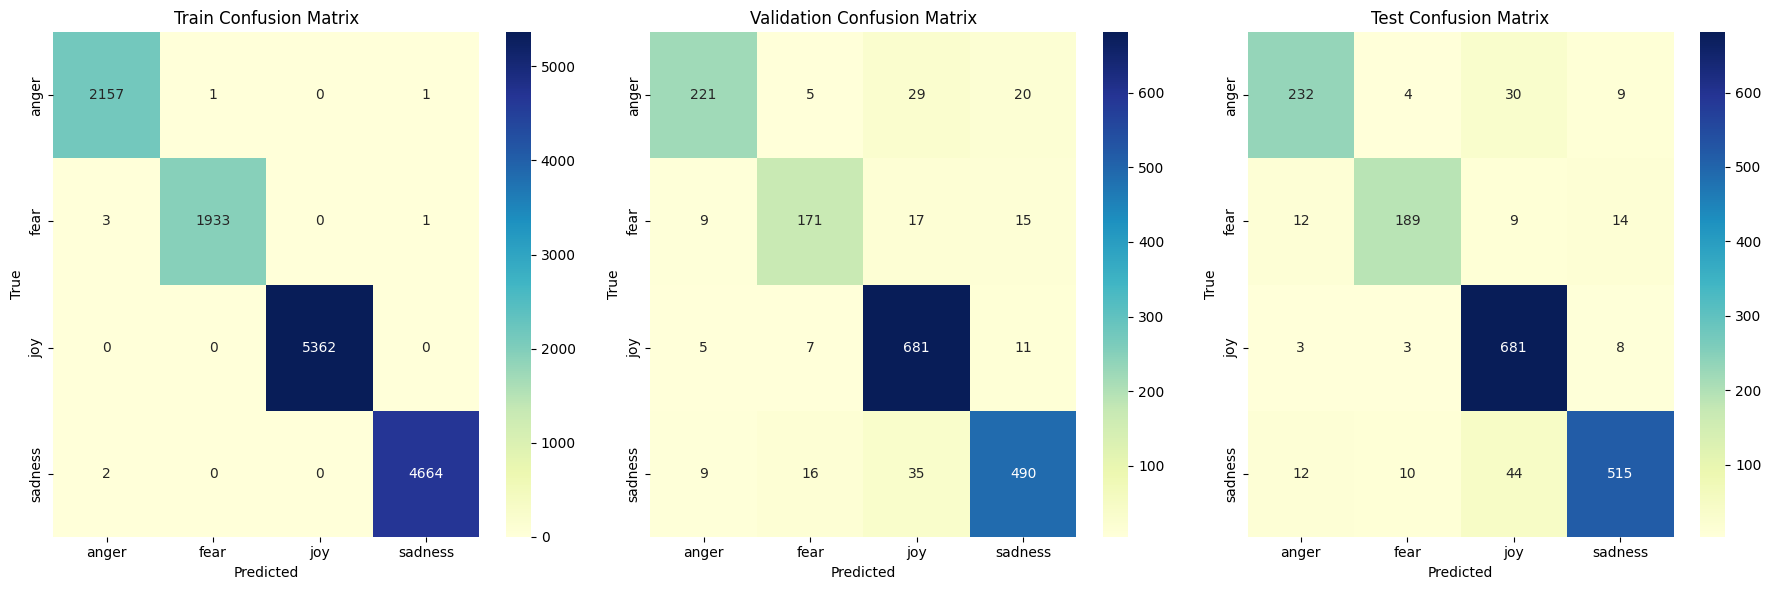

In [13]:
plot_confusion_matrices(
    train_df['Emotion'], train_pred,
    val_df['Emotion'], val_pred,
    test_df['Emotion'], test_pred,
    pipeline.classes_
)

In [14]:
from sklearn.svm import SVC
text_processor = TextProcessor(lower=True, stem=False)
vectorizer = CountVectorizer(max_features=3000)
svm = SVC(kernel="linear",gamma=1, C=.5, random_state=42)
svm_pipeline = Pipeline(
    [
        ("text_processing", text_processor),
        ("vectorizer", vectorizer),
        ("svm", svm),
    ]
)
svm_pipeline.fit(train_df['Text'], train_df['Emotion']) 

Pipeline(steps=[('text_processing', TextProcessor(lower=True)),
                ('vectorizer', CountVectorizer(max_features=3000)),
                ('svm', SVC(C=0.5, gamma=1, kernel='linear', random_state=42))])

In [15]:
train_pred = svm_pipeline.predict(x_train_procceced)
train_accuracy = accuracy_score(train_df['Emotion'], train_pred)
print("Train set accuracy:", train_accuracy)

# Validation set accuracy
val_pred = svm_pipeline.predict(x_val_procceced)
val_accuracy = accuracy_score(val_df['Emotion'], val_pred)
print("Validation set accuracy:", val_accuracy)

# Test set accuracy
test_pred = svm_pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("Test set accuracy:", test_accuracy)

svm_acc= test_accuracy

Train set accuracy: 0.9805295950155763
Validation set accuracy: 0.9287765651924181
Test set accuracy: 0.9374647887323944


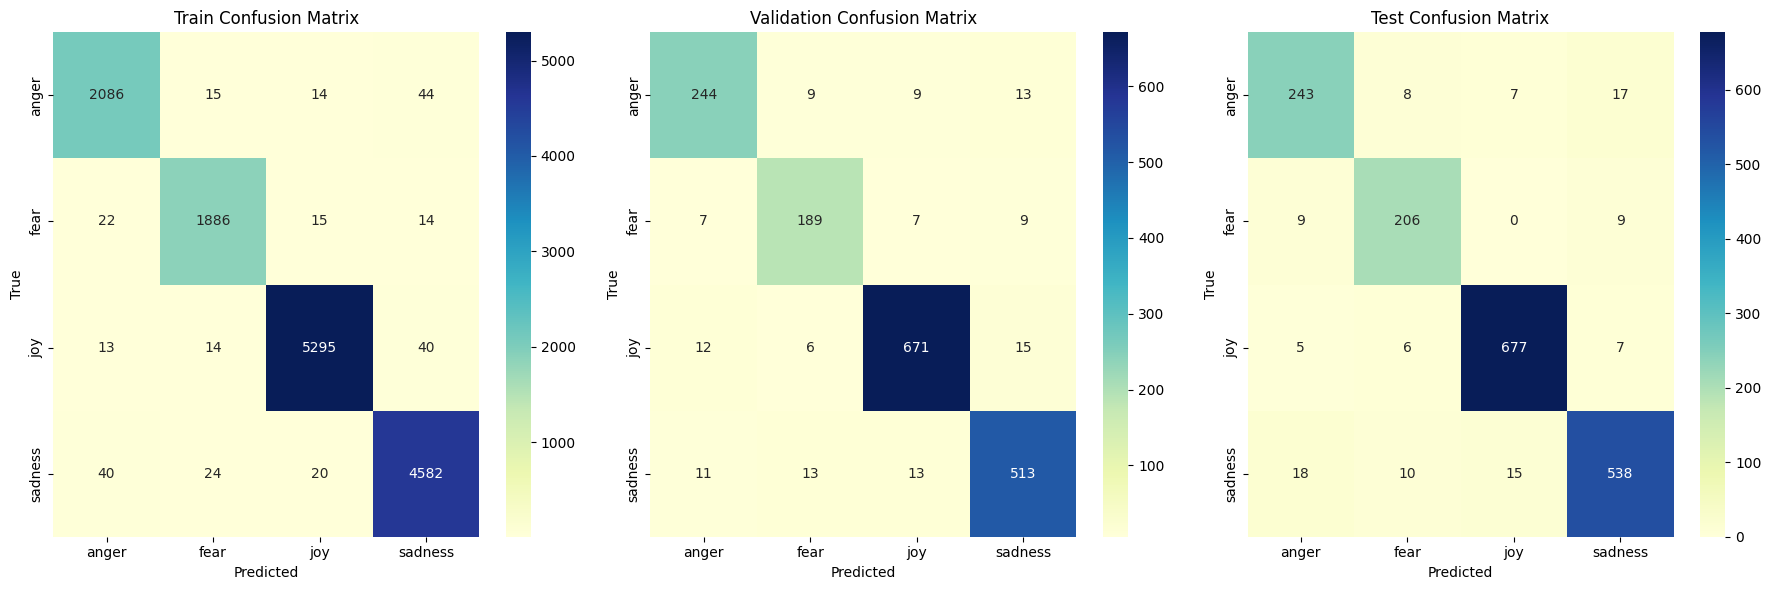

In [16]:
plot_confusion_matrices(
    train_df['Emotion'], train_pred,
    val_df['Emotion'], val_pred,
    test_df['Emotion'], test_pred,
    pipeline.classes_
)

In [17]:
from sklearn.linear_model import LogisticRegression
text_processor = TextProcessor(lower=True, stem=False)

vectorizer = CountVectorizer(max_features=3000)

logistics = LogisticRegression(random_state=42, max_iter=1000)

logs_pipeline = Pipeline([
    ("text_processing", text_processor), # Text processing step
    ("vectorizer", CountVectorizer()),   # CountVectorizer step
    ("classifier", logistics)  # RandomForestClassifier step
])

logs_pipeline.fit(train_df['Text'], train_df['Emotion'])


Pipeline(steps=[('text_processing', TextProcessor(lower=True)),
                ('vectorizer', CountVectorizer()),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [18]:
train_pred = logs_pipeline.predict(x_train_procceced)
train_accuracy = accuracy_score(train_df['Emotion'], train_pred)
print("Train set accuracy:", train_accuracy)

# Validation set accuracy
val_pred = logs_pipeline.predict(x_val_procceced)
val_accuracy = accuracy_score(val_df['Emotion'], val_pred)
print("Validation set accuracy:", val_accuracy)

# Test set accuracy
test_pred = logs_pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("Test set accuracy:", test_accuracy)

logs_acc = test_accuracy

Train set accuracy: 0.9921410365335599
Validation set accuracy: 0.9316484778862723
Test set accuracy: 0.9391549295774648


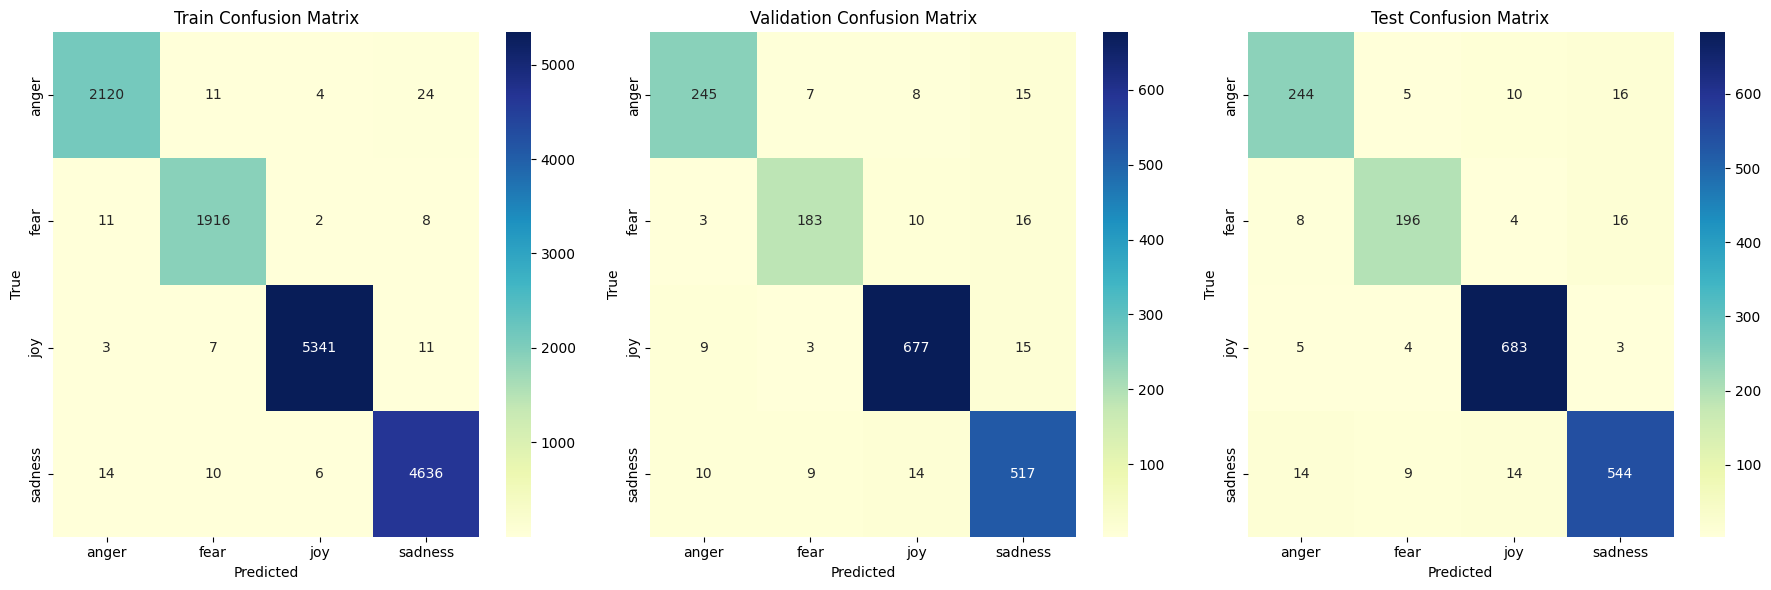

In [19]:
plot_confusion_matrices(
    train_df['Emotion'], train_pred,
    val_df['Emotion'], val_pred,
    test_df['Emotion'], test_pred,
    pipeline.classes_
)

In [20]:
from sklearn.naive_bayes import MultinomialNB
text_processor = TextProcessor(lower=True, stem=True)

vectorizer = CountVectorizer(max_features=3000)

MNB = MultinomialNB()

MNB_pipeline = Pipeline([
    ("text_processing", text_processor), # Text processing step
    ("vectorizer", CountVectorizer()),   # CountVectorizer step
    ("classifier", MNB)  # RandomForestClassifier step
])

MNB_pipeline.fit(train_df['Text'], train_df['Emotion'])


Pipeline(steps=[('text_processing', TextProcessor(lower=True, stem=True)),
                ('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [21]:
train_pred = MNB_pipeline.predict(x_train_procceced)
train_accuracy = accuracy_score(train_df['Emotion'], train_pred)
print("Train set accuracy:", train_accuracy)

# Validation set accuracy
val_pred = MNB_pipeline.predict(x_val_procceced)
val_accuracy = accuracy_score(val_df['Emotion'], val_pred)
print("Validation set accuracy:", val_accuracy)

# Test set accuracy
test_pred = MNB_pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("Test set accuracy:", test_accuracy)

MNB_acc = test_accuracy

Train set accuracy: 0.9346502407250071
Validation set accuracy: 0.8655944859276278
Test set accuracy: 0.8490140845070423


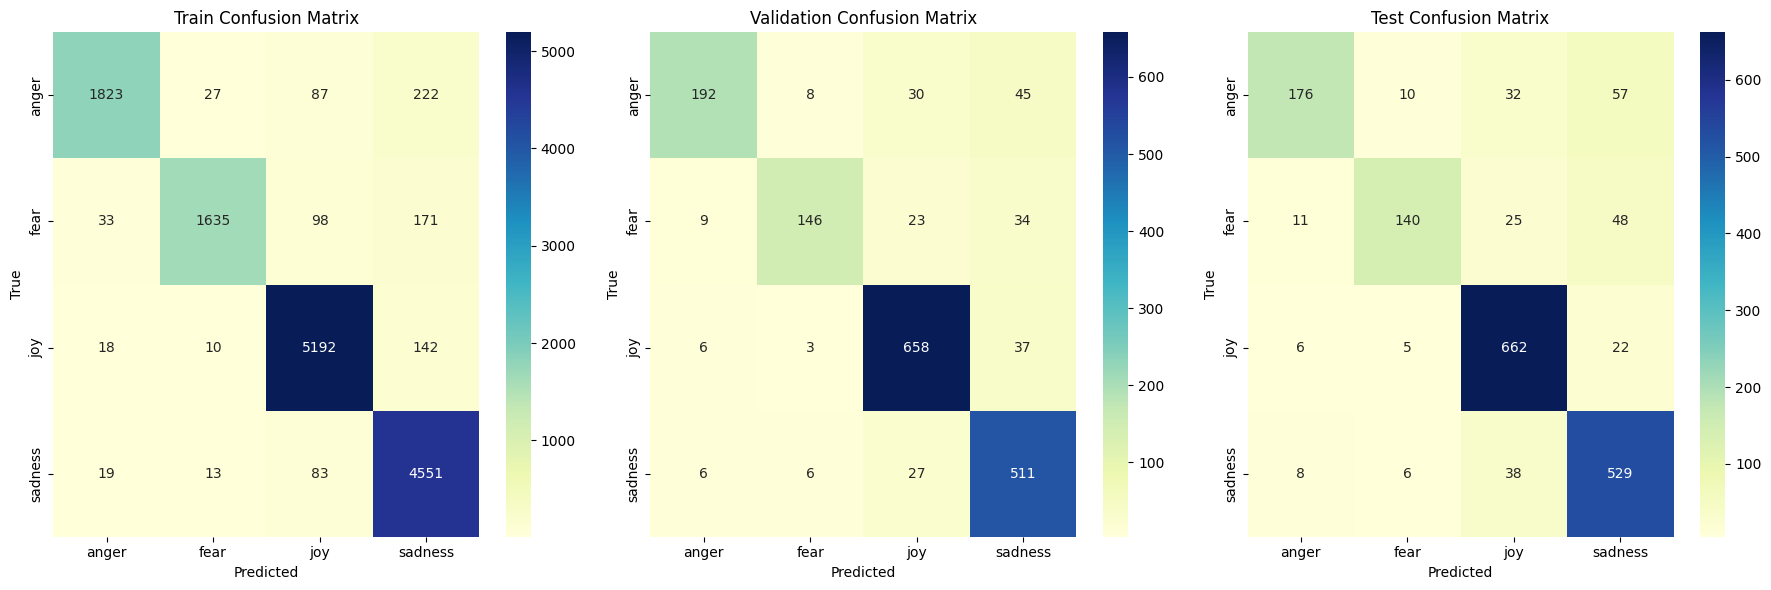

In [22]:
plot_confusion_matrices(
    train_df['Emotion'], train_pred,
    val_df['Emotion'], val_pred,
    test_df['Emotion'], test_pred,
    pipeline.classes_
)

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
text_processor = TextProcessor(lower=True, stem=False)

vectorizer = CountVectorizer(max_features=3000)

GB = GradientBoostingClassifier()

GB_pipeline = Pipeline([
    ("text_processing", text_processor), # Text processing step
    ("vectorizer", CountVectorizer()),   # CountVectorizer step
    ("classifier", GB)  # RandomForestClassifier step
])

GB_pipeline.fit(train_df['Text'], train_df['Emotion'])


Pipeline(steps=[('text_processing', TextProcessor(lower=True)),
                ('vectorizer', CountVectorizer()),
                ('classifier', GradientBoostingClassifier())])

In [24]:
train_pred = GB_pipeline.predict(x_train_procceced)
train_accuracy = accuracy_score(train_df['Emotion'], train_pred)
print("Train set accuracy:", train_accuracy)

# Validation set accuracy
val_pred = GB_pipeline.predict(x_val_procceced)
val_accuracy = accuracy_score(val_df['Emotion'], val_pred)
print("Validation set accuracy:", val_accuracy)

# Test set accuracy
test_pred = GB_pipeline.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("Test set accuracy:", test_accuracy)

GB_acc = test_accuracy

Train set accuracy: 0.8992495043896913
Validation set accuracy: 0.8759333716255026
Test set accuracy: 0.8783098591549295


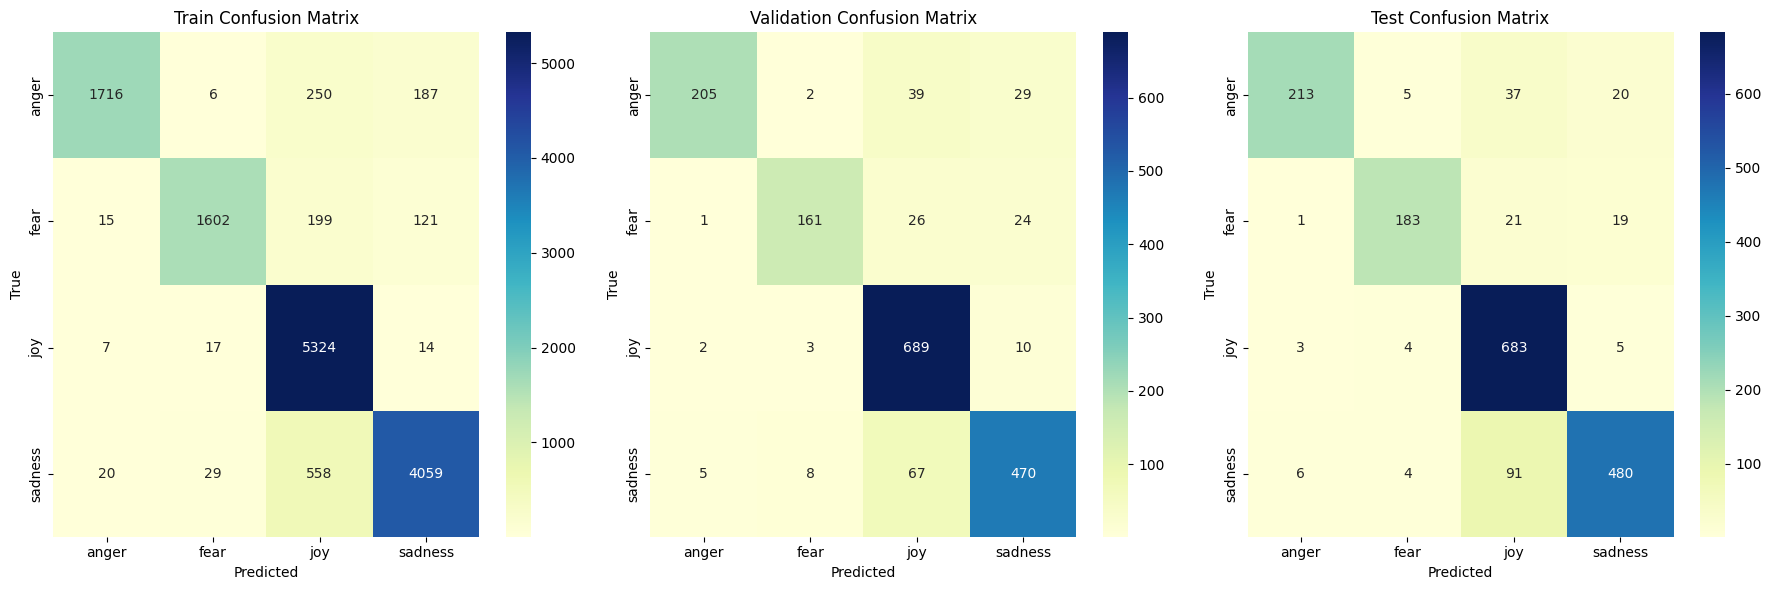

In [25]:
plot_confusion_matrices(
    train_df['Emotion'], train_pred,
    val_df['Emotion'], val_pred,
    test_df['Emotion'], test_pred,
    pipeline.classes_
)

<div style="text-align:center; background-color:#dc3545; padding:20px;">
  <h1 style="font-size:36px; color:#ffeeba;"><b>4.Best Model Implementation</b></h1>
</div>


### The code segment creates a bar plot to visualize the accuracies of different machine learning models.

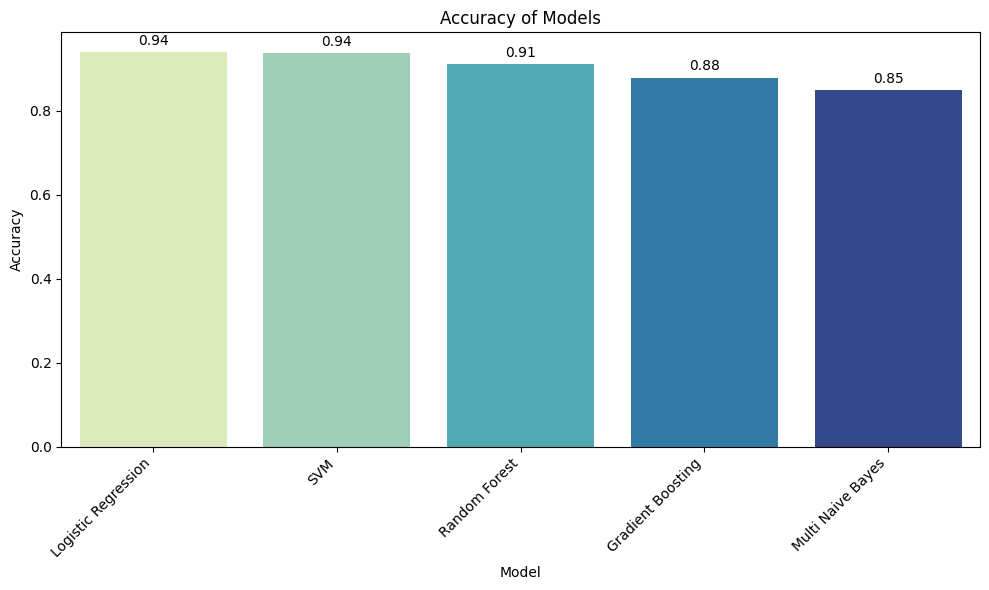

In [26]:
accuracies = {
    "Multi Naive Bayes": MNB_acc,
    "SVM": svm_acc,
    "Random Forest": RF_acc,
    "Logistic Regression": logs_acc,
    "Gradient Boosting": GB_acc
}

# Sort accuracies in descending order
sorted_accuracies = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

# Extract model names and accuracies
model_names = [model[0] for model in sorted_accuracies]
accuracy_values = [model[1] for model in sorted_accuracies]

# Create countplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=model_names, y=accuracy_values, palette="YlGnBu")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy of Models")
plt.xticks(rotation=45, ha='right')

# Annotate each bar with its accuracy value
for i, v in enumerate(accuracy_values):
    ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


### The code uses a technique called "Voting Classifier" to combine predictions from multiple machine learning models. It includes three models: Random Forest Classifier, Logistic Regression, and Support Vector Machine. These models are trained on textual data and corresponding emotions. The Voting Classifier learns from these individual models to make a final prediction.

In [27]:
from sklearn.ensemble import VotingClassifier

estimators=[
        ("RFC", pipeline),
        ("Logistics Regression", logs_pipeline),
        ("SVM", svm_pipeline)]


voting_classifier = VotingClassifier(estimators, voting='hard')
voting_classifier.fit(train_df['Text'], train_df['Emotion'])


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.8s finished


VotingClassifier(estimators=[('RFC',
                              Pipeline(steps=[('text_processing',
                                               TextProcessor(lower=True)),
                                              ('vectorizer', CountVectorizer()),
                                              ('classifier',
                                               RandomForestClassifier(n_estimators=50,
                                                                      n_jobs=-1,
                                                                      random_state=42,
                                                                      verbose=1))])),
                             ('Logistics Regression',
                              Pipeline(steps=[('text_processing',
                                               TextProcessor(lower=True)),
                                              ('vectorizer', CountVectorizer()),
                                              ('classifier',
                                               LogisticRegression(max_iter=1000,
                                                                  random_state=42))])),
                             ('SVM',
                              Pipeline(steps=[('text_processing',
                                               TextProcessor(lower=True)),
                                              ('vectorizer',
                                               CountVectorizer(max_features=3000)),
                                              ('svm',
                                               SVC(C=0.5, gamma=1,
                                                   kernel='linear',
                                                   random_state=42))]))])

In [28]:

train_pred = voting_classifier.predict(x_train_procceced)
train_accuracy = accuracy_score(train_df['Emotion'], train_pred)
print("Train set accuracy:", train_accuracy)

# Validation set accuracy
val_pred = voting_classifier.predict(x_val_procceced)
val_accuracy = accuracy_score(val_df['Emotion'], val_pred)
print("Validation set accuracy:", val_accuracy)

# Test set accuracy
test_pred = voting_classifier.predict(x_test_procceced)
test_accuracy = accuracy_score(test_df['Emotion'], test_pred)
print("Test set accuracy:", test_accuracy)

model_accuracy = test_accuracy

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


Train set accuracy: 0.9935570659869726


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Validation set accuracy: 0.9299253302699598


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Test set accuracy: 0.9430985915492958


<div style="text-align:center; background-color:#dc3545; padding:20px;">
  <h1 style="font-size:36px; color:#ffeeba;"><b>5.Model Validation </b></h1>
</div>


In [29]:
print('Our Machine Learning model has an accuracy of {:.2f}%'.format(model_accuracy * 100))

Our Machine Learning model has an accuracy of 94.31%


In [30]:
custom_text = "I'm feeling happy and excited today"
predicted_emotion = voting_classifier.predict([custom_text])
print("Predicted Emotion:", predicted_emotion[0])

Predicted Emotion: joy


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


In [31]:
custom_text = "I'm realy don't even know why this is done for me!"
predicted_emotion = voting_classifier.predict([custom_text])
print("Predicted Emotion:", predicted_emotion[0])

Predicted Emotion: sadness


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


In [32]:
custom_text = "I feel overwhelmed with sorrow"
predicted_emotion = voting_classifier.predict([custom_text])
print("Predicted Emotion:", predicted_emotion[0])

Predicted Emotion: fear


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
